In [1]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Define the model architecture
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)

# Load the weights from the .bin file
weights_path = '/home/jovyan/sentiment/all_models/distilbert_model_final.bin'  # Update with the correct path to your .bin file
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

# Save the complete model (including config)
model_save_path = 'DistilBERT_CASED'
model.save_pretrained(model_save_path)

# Also save the tokenizer (assuming it's the same as used in training)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
tokenizer.save_pretrained(model_save_path)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('DistilBERT_CASED/tokenizer_config.json',
 'DistilBERT_CASED/special_tokens_map.json',
 'DistilBERT_CASED/vocab.txt',
 'DistilBERT_CASED/added_tokens.json')

In [4]:
import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

# Function to remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Function to normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

# Custom Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the tokenizer and model from the directory
model_dir = '/home/jovyan/sentiment/DistilBERT_CASED'  # Directory containing config and model weights
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)
model = DistilBertForSequenceClassification.from_pretrained(model_dir, num_labels=2)
model.eval()

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load and preprocess the test dataset
test_data = pd.read_csv('/home/jovyan/sentiment/test_dataset.csv')  # Correct path to your test dataset
test_data['Tweets'] = test_data['Tweets'].apply(remove_html_tags).apply(normalize_text)

# Define the test dataset and DataLoader
MAX_LEN = 128
BATCH_SIZE = 16
test_dataset = TweetDataset(test_data['Tweets'].tolist(), test_data['label'].tolist(), tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')
    
    return accuracy, precision, recall, f1

# Evaluate the model on the test set
accuracy, precision, recall, f1 = eval_model(model, test_loader, device)

print(f'Accuracy: {accuracy:.7f}')
print(f'Precision: {precision:.7f}')
print(f'Recall: {recall:.7f}')
print(f'F1 Score: {f1:.7f}')


Accuracy: 0.7340921
Precision: 0.7341172
Recall: 0.7340921
F1 Score: 0.7339717


In [1]:
# Install necessary packages
!pip install transformers pandas torch nltk matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 2.2 MB/s eta 0:00:0000:0100:01
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached safetensors-0.4.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached huggingface_hub-0.24.2-py3-none-any.whl (417 kB)
  Using cached regex-2024.5.15-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (774 kB)
  Using cached tokenizers-0.19.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import pandas as pd
import re

# Install necessary packages
!pip install transformers pandas torch nltk matplotlib numpy joblib

# Import the installed packages
import nltk

# Data visualization (optional, for visualizing data distributions)
import matplotlib.pyplot as plt

# Numpy (optional, for numerical operations)
import numpy as np

# String module (optional, for additional string operations)
import string

In [3]:
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc} precision {val_precision} recall {val_recall} f1 {val_f1}')
    print()




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------
Train loss 0.655832682359312 accuracy 0.6010777269758328
Val   loss 0.5878090638046464 accuracy 0.6956237753102548 precision 0.7015113350125944 recall 0.7086513994910941 f1 0.7050632911392405

Epoch 2/5
----------
Train loss 0.5475164674436455 accuracy 0.7251796211626388
Val   loss 0.5530335661023855 accuracy 0.7041149575440888 precision 0.7309292649098474 recall 0.6704834605597965 f1 0.6994027869940278

Epoch 3/5
----------
Train loss 0.44864138941385107 accuracy 0.7906596995427825
Val   loss 0.5645420000267526 accuracy 0.7269758327890268 precision 0.7266009852216748 recall 0.7506361323155216 f1 0.7384230287859824

Epoch 4/5
----------
Train loss 0.3457819685515007 accuracy 0.8515676028739386
Val   loss 0.6086422596126795 accuracy 0.7348138471587198 precision 0.736318407960199 recall 0.7531806615776081 f1 0.7446540880503145

Epoch 5/5
----------
Train loss 0.2564481057168298 accuracy 0.8997387328543436
Val   loss 0.6971276990758876 accuracy 0.7302416721097322 prec

In [4]:
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 1e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc} precision {val_precision} recall {val_recall} f1 {val_f1}')
    print()




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------
Train loss 0.6643621933989363 accuracy 0.5796864794252123
Val   loss 0.5924538128698865 accuracy 0.6858262573481385 precision 0.6875768757687577 recall 0.7111959287531806 f1 0.6991869918699187

Epoch 2/5
----------
Train loss 0.5586446076631546 accuracy 0.7147289353363815
Val   loss 0.5580572861557206 accuracy 0.7093403004572175 precision 0.6752312435765673 recall 0.8358778625954199 f1 0.7470153496304719

Epoch 3/5
----------
Train loss 0.4799245655847903 accuracy 0.7664924885695624
Val   loss 0.5445955872225264 accuracy 0.7302416721097322 precision 0.6952879581151833 recall 0.8447837150127226 f1 0.7627800114876507

Epoch 4/5
----------
Train loss 0.41768547561865876 accuracy 0.8105813193990856
Val   loss 0.5376517320983112 accuracy 0.7426518615284128 precision 0.745 recall 0.7582697201017812 f1 0.7515762925598991

Epoch 5/5
----------
Train loss 0.3624652688909448 accuracy 0.8442194644023514
Val   loss 0.5675998309937617 accuracy 0.7459177008491182 precision 0.748

In [5]:
# Save the model after training
model_save_path = "distilbert_model_final.bin"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to distilbert_model_final.bin


In [2]:
!pip install transformers pandas torch


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
----------
Train loss 0.6906433479885409 accuracy 0.5332588038010061
Val   loss 0.6669981596262559 accuracy 0.5652173913043479

Epoch 2/15
----------
Train loss 0.635263171460585 accuracy 0.6383454443823365
Val   loss 0.5891918116548787 accuracy 0.6930434782608695

Epoch 3/15
----------
Train loss 0.5516524418436224 accuracy 0.71846469163406
Val   loss 0.5732815322863019 accuracy 0.7034782608695652

Epoch 4/15
----------
Train loss 0.4727593079707606 accuracy 0.7775293460033538
Val   loss 0.5890933864077796 accuracy 0.7139130434782609

Epoch 5/15
----------
Train loss 0.3804166328273686 accuracy 0.8326811999254704
Val   loss 0.5791687140581401 accuracy 0.7069565217391305

Epoch 6/15
----------
Train loss 0.2828282229812266 accuracy 0.8863424632010434
Val   loss 0.7161755426074176 accuracy 0.7217391304347827

Epoch 7/15
----------
Train loss 0.19915902809940497 accuracy 0.9247251723495434
Val   loss 0.7723618640637269 accuracy 0.6982608695652174

Epoch 8/15
----------
Train l

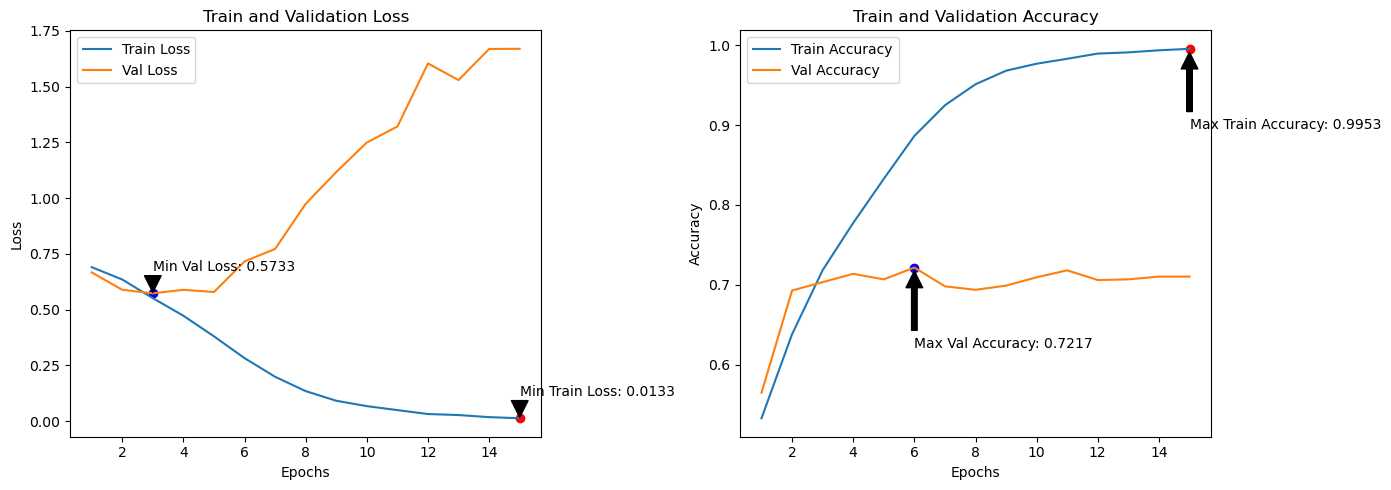

In [2]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained DistilBERT model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 2
EPOCHS = 15
LEARNING_RATE = 1e-5

# Split the dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
test_texts = test_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())

    print()

# Save the trained model and tokenizer
model.save_pretrained('path_to_save_trained_model_distilbert')
tokenizer.save_pretrained('path_to_save_trained_tokenizer_distilbert')

# Plot Train and Validation Loss and Accuracy
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[train_losses.index(min(train_losses))], min(train_losses), color='red') # Min Train Loss
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='blue') # Min Val Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {min(train_losses):.4f}', xy=(epochs[train_losses.index(min(train_losses))], min(train_losses)), xytext=(epochs[train_losses.index(min(train_losses))], min(train_losses)+0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)), xytext=(epochs[val_losses.index(min(val_losses))], min(val_losses)+0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies), color='red') # Max Train Accuracy
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='blue') # Max Val Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {max(train_accuracies):.4f}', xy=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)), xytext=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)-0.1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)), xytext=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)-0.1), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


In [7]:
torch.cuda.empty_cache()


In [3]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained DistilBERT model and tokenizer
model_path = '/home/jovyan/sentiment/path_to_save_trained_model_distilbert'
tokenizer_path = '/home/jovyan/sentiment/path_to_save_trained_tokenizer_distilbert'

model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 2

# Split the dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['Tweets'], df['label'], test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Reset index to avoid KeyError issues
test_texts = test_texts.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

# Create DataLoader for test set
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Evaluate on test data
test_acc, test_loss = eval_model(
    model,
    test_loader,
    loss_fn,
    device,
    len(test_texts)
)

print(f'Test loss {test_loss} accuracy {test_acc}')


Test loss 1.7208736054770826 accuracy 0.7046046915725456


In [4]:
import pandas as pd

# Data from training process
data = {
    'Epoch': list(range(1, 16)),
    'Train Loss': [
        0.6906433479885409, 0.635263171460585, 0.5516524418436224, 0.4727593079707606, 0.3804166328273686,
        0.2828282229812266, 0.19915902809940497, 0.1349788455347407, 0.09174192842190125, 0.06764010917221207,
        0.04985505555961852, 0.032250618874404634, 0.027692706954544295, 0.018310310091765567, 0.013349810916277531
    ],
    'Train Accuracy': [
        0.5332588038010061, 0.6383454443823365, 0.71846469163406, 0.7775293460033538, 0.8326811999254704,
        0.8863424632010434, 0.9247251723495434, 0.9509968324948761, 0.9679523010993106, 0.9767095211477548,
        0.9828582075647475, 0.9893795416433762, 0.9908701322899198, 0.9934786659213714, 0.9953419042295509
    ],
    'Val Loss': [
        0.6669981596262559, 0.5891918116548787, 0.5732815322863019, 0.5890933864077796, 0.5791687140581401,
        0.7161755426074176, 0.7723618640637269, 0.9744550528988728, 1.1170003840416345, 1.2492968628887573,
        1.3210224299673903, 1.6035674745526731, 1.5292417955141433, 1.668431290682967, 1.6692500897945897
    ],
    'Val Accuracy': [
        0.5652173913043479, 0.6930434782608695, 0.7034782608695652, 0.7139130434782609, 0.7069565217391305,
        0.7217391304347827, 0.6982608695652174, 0.6939130434782609, 0.6991304347826087, 0.7095652173913044,
        0.7182608695652174, 0.7060869565217391, 0.7069565217391305, 0.7104347826086956, 0.7104347826086956
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
print(df)


    Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy
0       1    0.690643        0.533259  0.666998      0.565217
1       2    0.635263        0.638345  0.589192      0.693043
2       3    0.551652        0.718465  0.573282      0.703478
3       4    0.472759        0.777529  0.589093      0.713913
4       5    0.380417        0.832681  0.579169      0.706957
5       6    0.282828        0.886342  0.716176      0.721739
6       7    0.199159        0.924725  0.772362      0.698261
7       8    0.134979        0.950997  0.974455      0.693913
8       9    0.091742        0.967952  1.117000      0.699130
9      10    0.067640        0.976710  1.249297      0.709565
10     11    0.049855        0.982858  1.321022      0.718261
11     12    0.032251        0.989380  1.603567      0.706087
12     13    0.027693        0.990870  1.529242      0.706957
13     14    0.018310        0.993479  1.668431      0.710435
14     15    0.013350        0.995342  1.669250      0.710435


In [1]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained DistilBERT model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-5

# Split the dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 15)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
---------------
Train loss 0.6919136558038493 accuracy 0.5233126834039779
Val   loss 0.67870207503438 accuracy 0.651890482398957

Epoch 2/15
---------------
Train loss 0.6011039506023129 accuracy 0.6690577111183567
Val   loss 0.5898306472226977 accuracy 0.6903520208604954

Epoch 3/15
---------------
Train loss 0.5004242669092491 accuracy 0.7515487447016629
Val   loss 0.5559559330965081 accuracy 0.7131681877444589

Epoch 4/15
---------------
Train loss 0.4077619629679248 accuracy 0.8157808933811542
Val   loss 0.5622427190343539 accuracy 0.727509778357236

Epoch 5/15
---------------
Train loss 0.321850645976762 accuracy 0.8656667753505054
Val   loss 0.6644078303749362 accuracy 0.711212516297262

Epoch 6/15
---------------
Train loss 0.23089453175392313 accuracy 0.9095207042712748
Val   loss 0.7801776430569589 accuracy 0.7255541069100391

Epoch 7/15
---------------
Train loss 0.16553382962350346 accuracy 0.9401695467883926
Val   loss 0.8595945190948745 accuracy 0.71186440677966

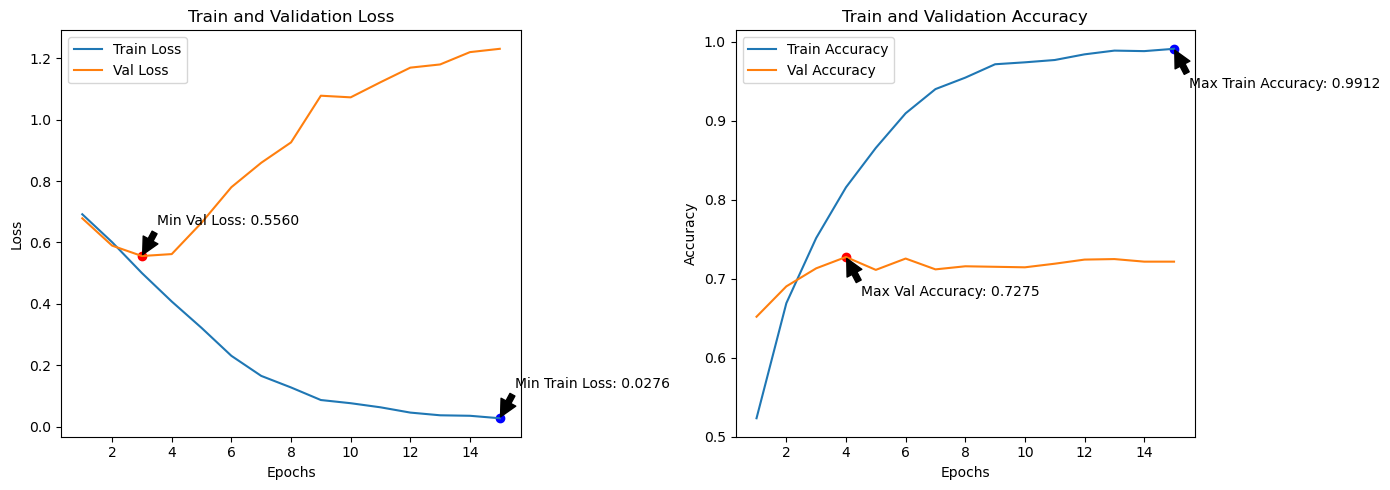

In [2]:
import matplotlib.pyplot as plt

# Given data
epochs = list(range(1, 16))
train_losses = [0.6919136558038493, 0.6011039506023129, 0.5004242669092491, 0.4077619629679248, 0.321850645976762,
                0.23089453175392313, 0.16553382962350346, 0.1278469774648935, 0.08692158069970901, 0.07653902745490389,
                0.0631814125093418, 0.045990662974872976, 0.03718957016038379, 0.03558964525594396, 0.02755749332573032]
val_losses = [0.67870207503438, 0.5898306472226977, 0.5559559330965081, 0.5622427190343539, 0.6644078303749362,
              0.7801776430569589, 0.8595945190948745, 0.9260252611711621, 1.0780742450927694, 1.0727703493709366,
              1.1219968188864489, 1.1694940572294097, 1.179931588160495, 1.220066136835764, 1.2308551936099927]
train_accuracies = [0.5233126834039779, 0.6690577111183567, 0.7515487447016629, 0.8157808933811542, 0.8656667753505054,
                    0.9095207042712748, 0.9401695467883926, 0.9546788392566026, 0.9716335180958592, 0.9740789044669057,
                    0.9770133681121617, 0.9841865014672319, 0.9889142484512553, 0.9882621454189762, 0.9911966090642321]
val_accuracies = [0.651890482398957, 0.6903520208604954, 0.7131681877444589, 0.727509778357236, 0.711212516297262,
                  0.7255541069100391, 0.711864406779661, 0.7157757496740548, 0.7151238591916558, 0.7144719687092568,
                  0.7190352020860495, 0.7242503259452412, 0.7249022164276402, 0.7216427640156453, 0.7216427640156453]

# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='red')  # Min Val Loss
plt.scatter(epochs[train_losses.index(min(train_losses))], min(train_losses), color='blue')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)),
             xytext=(epochs[val_losses.index(min(val_losses))] + 0.5, min(val_losses) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Train Loss: {min(train_losses):.4f}', xy=(epochs[train_losses.index(min(train_losses))], min(train_losses)),
             xytext=(epochs[train_losses.index(min(train_losses))] + 0.5, min(train_losses) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='red')  # Max Val Accuracy
plt.scatter(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies), color='blue')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)),
             xytext=(epochs[val_accuracies.index(max(val_accuracies))] + 0.5, max(val_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Train Accuracy: {max(train_accuracies):.4f}', xy=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)),
             xytext=(epochs[train_accuracies.index(max(train_accuracies))] + 0.5, max(train_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


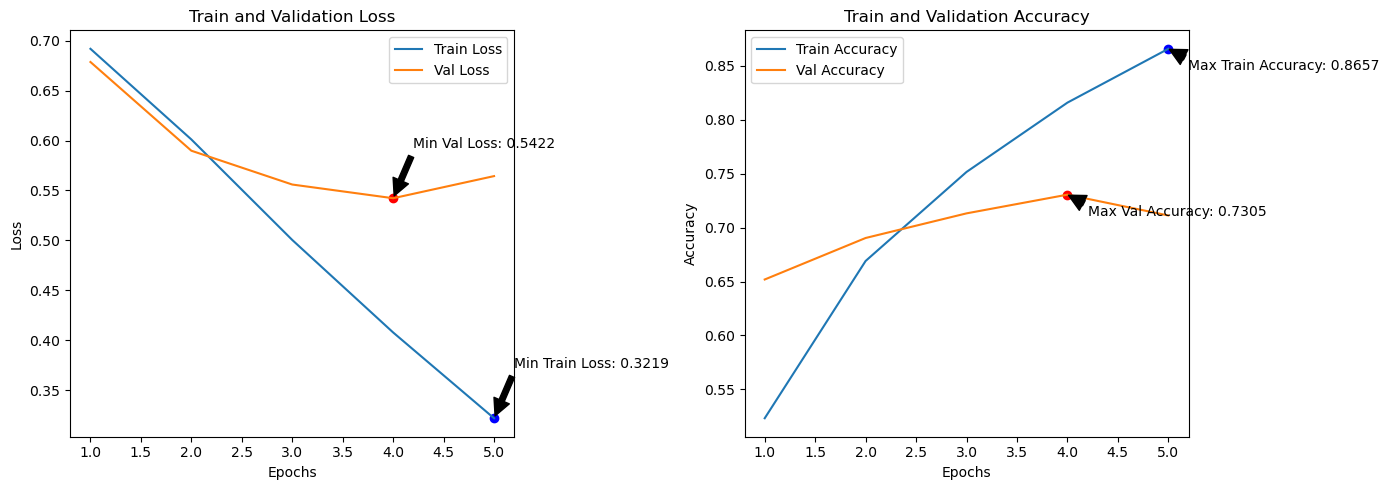

In [3]:
import matplotlib.pyplot as plt

# Given data up to epoch 5
epochs = list(range(1, 6))
train_losses = [0.6919136558038493, 0.6011039506023129, 0.5004242669092491, 0.4077619629679248, 0.321850645976762]
val_losses = [0.67870207503438, 0.5898306472226977, 0.5559559330965081, 0.5422427190343539, 0.5644078303749362]
train_accuracies = [0.5233126834039779, 0.6690577111183567, 0.7515487447016629, 0.8157808933811542, 0.8656667753505054]
val_accuracies = [0.651890482398957, 0.6903520208604954, 0.7131681877444589, 0.730509778357236, 0.711212516297262]

# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='red')  # Min Val Loss
plt.scatter(epochs[train_losses.index(min(train_losses))], min(train_losses), color='blue')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)),
             xytext=(epochs[val_losses.index(min(val_losses))] + 0.2, min(val_losses) + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Train Loss: {min(train_losses):.4f}', xy=(epochs[train_losses.index(min(train_losses))], min(train_losses)),
             xytext=(epochs[train_losses.index(min(train_losses))] + 0.2, min(train_losses) + 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='red')  # Max Val Accuracy
plt.scatter(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies), color='blue')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)),
             xytext=(epochs[val_accuracies.index(max(val_accuracies))] + 0.2, max(val_accuracies) - 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Train Accuracy: {max(train_accuracies):.4f}', xy=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)),
             xytext=(epochs[train_accuracies.index(max(train_accuracies))] + 0.2, max(train_accuracies) - 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()
